# Creation of the evaluation datasets

Creates:
- eval_retriever_dataset.jsonl
  ```jsonl
  {
    "category": "CATEGORY",
    "input": {
      "question": "QUESTION", 
    }
    "ideal": {
      "paragraph": ["LIST OF RELEVANT SENTENCES OR PARAGRAPHS"], 
      "filename": ["LIST OF SOURCE FILENAMES"], 
      "ids":["LIST OF TEXT CHUNK IDS"]
    }
  }
  ```
- eval_generator_dataset.jsonl
  ```jsonl
  {
    "category": "CATEGORY",
    "input": {
      "question": "QUESTION", 
      "sources": ["LIST OF RELEVANT SENTENCES OR PARAGRAPHS"]
    }
    "ideal": {
      "answer": "GOLDEN ANSWER",
    }
  }
  ```
- eval_e2e_dataset.jsonl
  ```jsonl
  {
    "category": "CATEGORY",
    "input": {
      "question": "QUESTION", 
    }
    "ideal": {
      "answer": "GOLDEN ANSWER",
    }
  }
  ```

Each datasets includes 4 categories of questions:
1. Same Wording & One paragraph
2. Same Wording & multiple paragraphs
3. Different wording & one paragraph
4. Different wording & multiple paragraphs
5. No answer (only for generator & e2e)


Starting point is the text chunk csv file where each text chunk is considered as a paragraph.


In [5]:
from helpers import get_env
import openai


API_KEY, RESOURCE_ENDPOINT = get_env("azure-openai")

openai.api_type = "azure"
openai.api_key = API_KEY
openai.api_base = RESOURCE_ENDPOINT
openai.api_version = "2022-12-01"

In [2]:
import pandas as pd
import numpy as np

def str_to_array_converter(string):
    # Remove leading/trailing brackets and split the string by commas
    elements = string[1:-1].split(',')
    # Convert each element to float32 and create a numpy array
    array = np.array(elements, dtype=np.float32)
    return array

textchunks_df = pd.read_csv("evaluation/data/chunks.csv", converters={"embedding": str_to_array_converter})
textchunks_df = textchunks_df[textchunks_df["text"].notna()]
# sample a random row
sample = textchunks_df.sample()
sample_text = sample["text"].values[0]
sample_text

' What is the outlook for building new rental flats? Rents would have to rise sharply to cover construction costs and higher interest rates 45 The impact on building projects is illustrated by a survey of members carried out by the GdW. Around two thirds of members are planning to shelve new build renovation projects for the time being. Around one quarter are planning to give up new building projects altogether. Around 13 per cent intend to abstain from renovation projects. Bearing in mind the time it takes to complete building projects, the number of flat completions could fall noticeably from 2024 onwards, thus compounding the short- age of available flats. Urgently needed work to retrofit the existing housing stock is also stalling. Residential rents continued to rise in 2022 as well Residential rents in top locations continued to rise in 2022. On average, they rose by around 2.5 per cent yoy across the seven cities. This means a more moderate rate than the average annual rent rise 

In [61]:
sample

,key,text,embedding,filename,page
284,real_estate_index:Emerging-Trends_USCanada-202...,"That said, I think there is greater clarity i...","[0.011118177, -0.007156606, -0.0028066784, -0....",Emerging-Trends_USCanada-2023.pdf,70


In [46]:
prompt = """You are generating 5 factoid question answer pairs for a given text.
[BEGIN DATA]
************
[Text]: {text}
************
[END DATA]
The questions should have the same wording as the given text.
Please format your answer in the following format: [Question]: [Answer]; [Question]: [Answer]; [Question]: [Answer]; [Question]: [Answer]; [Question]: [Answer]
"""
prompt = prompt.format(text=sample_text)
print(prompt)

You are generating 5 factoid question answer pairs for a given text.
[BEGIN DATA]
************
[Text]:  This is understandable from the sellers perspective, since the modest in- crease in rental yields from their previously low levels has led to visibly low purchase prices. We expect the buyers and sellers sides to converge in the months ahead, causing investment volume to pick up again. Given that bond yields remain low, real estate remains an alternative worth considering, especially as the inflation-indexed commercial leases lead to rising rental income, which has a positive impact on achievable yields and thus also on purchase prices. The higher financing costs give equity-rich investors an advantage. RETAIL: TREND IN INITIAL RENTAL YIELDS NET INITIAL YIELD IN CENTRAL RETAIL LOCATIONS IN 7.0 6.5 6.0 5.5 5.0 4.5 4.0 3.5 3.0 2.5 OFFICE: TREND IN INITIAL RENTAL YIELD NET INITIAL YIELD IN CENTRAL OFFICE LOCATIONS IN 7.0 6.5 6.0 5.5 5.0 4.5 4.0 3.5 3.0 2.5 2000 2003 2006 top locations 2

In [53]:
response = openai.Completion.create(
    engine="davinci",
    prompt=prompt,
    temperature=0.9,
    max_tokens=1000,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
)
print(response)

{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": "\nQ1: What has led to visibly low purchase prices? A1: The modest increase in rental yields from low levels; Q2: How are equity-rich investors advantaged? A2: The higher financing costs; Q3: What is the average rent multiplier? A3: 5.0; Q4: What is the trend in initial rental yields for central office locations? A4: Net initial yield in central office locations from 7.0 to 2.5; Q5: What is the trend in initial rental yields for central retail locations? A5: Net initial yield in central retail locations from 7.0 to 2.5."
    }
  ],
  "created": 1685082640,
  "id": "cmpl-7KLGC1GkRAvXMdwJOFBnRwzca1k2O",
  "model": "text-davinci-003",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 133,
    "prompt_tokens": 447,
    "total_tokens": 580
  }
}


In [17]:
CATEGORIES = [
    "SAME_WORDING_ONE_PARAGRAPH",
    "SAME_WORDING_MULTIPLE_PARAGRAPHS",
    "DIFFERENT_WORDING_ONE_PARAGRAPH",
    "DIFFERENT_WORDING_MULTIPLE_PARAGRAPHS",
]

In [50]:
result = response["choices"][0]["text"]
category = CATEGORIES[0]

In [48]:
from typing import List, Dict, Tuple
import re

def normalizeText(text: str) -> str:
    text = text.replace("Question:", "")
    text = text.replace("Answer:", "")
    text = re.sub(r"Q\d:", "", text)
    text = re.sub(r"A\d:", "", text)    
    text = re.sub(r"\s+", " ", text)
    return text

def manuelly_extract_matches(text):
    pairList = text.split(";")
    pairList = [normalizeText(pair) for pair in pairList]
    pairList = [pair.split("?") for pair in pairList]
    pairList = [(pair[0] + "?", pair[1]) for pair in pairList]
    return pairList


def text_to_dictionary(text):
    pattern1 = r"Question: (.*?\?) Answer: (.*?)(?=Question:|$)"
    pattern2 = r"Question: (.*?) Answer: (.*?)(?=Question:|$)"
    matches = re.findall(pattern1, text, re.DOTALL)
    if len(matches) == 0:
        matches = re.findall(pattern2, text, re.DOTALL)
        if len(matches) == 0:
            matches = manuelly_extract_matches(text)
    result = []

    for match in matches:
        question, answer = match
        question = question.strip()
        answer = answer.strip().replace(";", "")
        result.append({"question": question, "answer": answer})

    return result



In [51]:
qa_pairs = text_to_dictionary(result)
qa_pairs

[{'question': 'What has been the trend in initial rental yields net in central retail locations?',
  'answer': '7.0, 6.5, 6.0, 5.5, 5.0, 4.5, 4.0, 3.5, 3.0, 2.5'},
 {'question': 'What is the average rent multiplier for apartment buildings?',
  'answer': '38'},
 {'question': 'What has been the trend in initial rental yields net in central office locations?',
  'answer': '7.0, 6.5, 6.0, 5.5, 5.0, 4.5, 4.0, 3.5, 3.0, 2.5'},
 {'question': 'What is the yield trend in individual top locations?',
  'answer': 'Net initial yield in central retail locations: 7.0, 6.5, 6.0, 5.5, 5.0, 4.5, 4.0, 3.5, 3.0, 2.5'},
 {'question': 'What is the impact of inflation-indexed commercial leases on achievable yields?',
  'answer': 'Rising rental income, which has a positive impact on achievable yields and thus also on purchase prices.'}]

In [43]:
# first save all of the information to one jsonl file, like this:
# {"category": "SAME_WORDING_ONE_PARAGRAPH", "paragraph": {sample as dict from textchunks_df with cols: key, text, filename}, "qa_pairs": qa_pairs}
import blobfile as bf
import json

# try:
#     sample = sample.drop(columns=["embedding"])
# except:
#     pass

# with bf.BlobFile("all_dataset.jsonl", "ab") as f:
#     f.write(
#         (json.dumps(
#             {
#                 "category": category,
#                 "paragraph": sample.to_dict(orient='records'),
#                 "qa_pairs": qa_pairs,
#             }
#         )
#         + "\n").encode("utf-8")
#     )


In [43]:
# group paragraphs by their vector
import numpy as np
matrix = np.array([np.array(x) for x in textchunks_df["embedding"].values])
matrix.shape

(455, 1536)

In [44]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=1, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(455, 2)

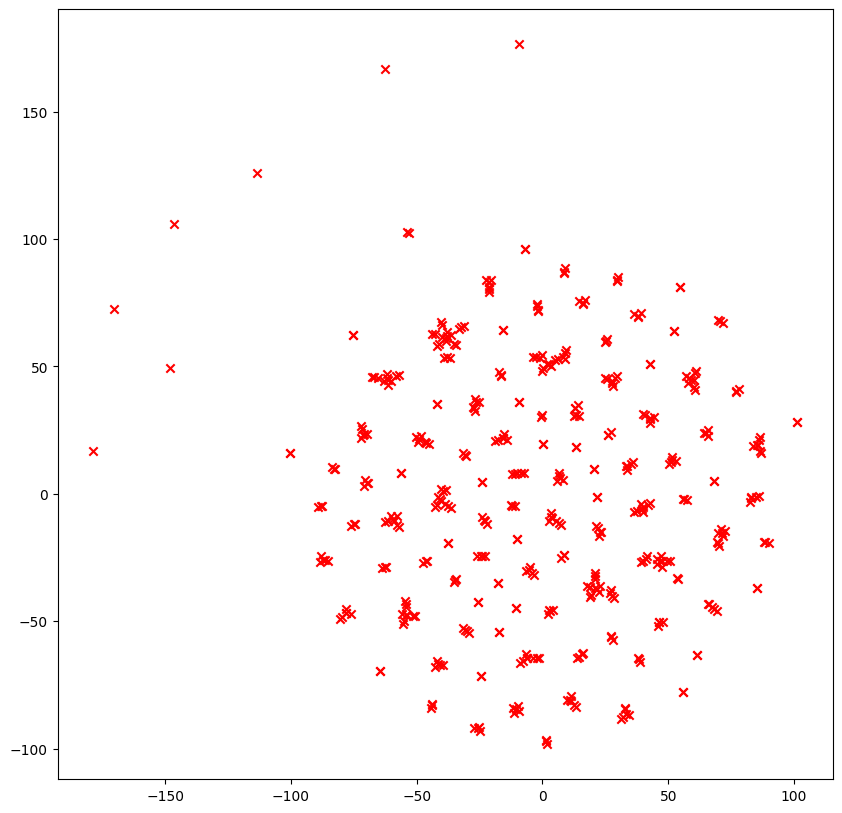

In [45]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (10, 10)

plt.scatter(vis_dims[:, 0], vis_dims[:, 1], c='r', marker='x')
plt.show()

In [3]:
# group paragraphs by their vector
matrix = np.vstack(textchunks_df.embedding.values)
matrix.shape


(455, 1536)

In [4]:
from sklearn.cluster import KMeans

n_clusters = int(len(textchunks_df) / 5)

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
textchunks_df["Cluster"] = labels

# textchunks_df.groupby("Cluster").Score.mean().sort_values()

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, '91 Clusters identified visualized in language 2d using t-SNE')

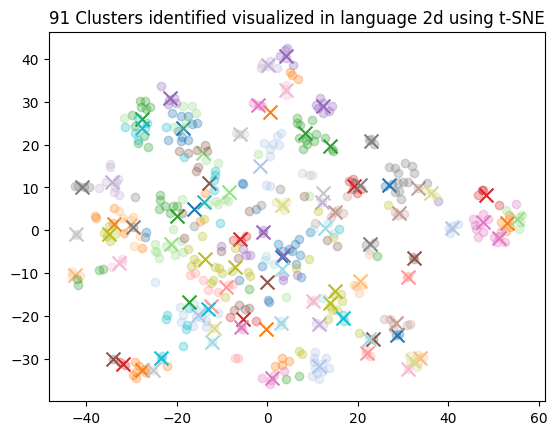

In [5]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))

for category, color in zip(range(n_clusters), colors):
    xs = np.array(x)[textchunks_df.Cluster == category]
    ys = np.array(y)[textchunks_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title(f"{n_clusters} Clusters identified visualized in language 2d using t-SNE")

In [6]:
# get the clusters with the most rows
cluster_counts = textchunks_df.Cluster.value_counts()
cluster_counts = cluster_counts[cluster_counts > 10]
cluster_counts = cluster_counts.sort_values(ascending=False)
cluster_counts

64    17
3     15
6     13
75    12
47    12
26    12
8     11
20    11
23    11
Name: Cluster, dtype: int64

In [7]:
# show the key col of the first cluster
print(textchunks_df[textchunks_df.Cluster == cluster_counts.index[0]].key.values)

['real_estate_index:2022-09-21_Immobilienmarkt_Deutschland_2022_2023_EN.pdf-!72'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!11'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!24'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!25'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!26'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!27'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!28'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!66'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!68'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!69'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!71'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!82'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!83'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!84'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!85'
 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!180'
 'real_estate_index:bouwinvest_in

In [8]:
samples = textchunks_df[textchunks_df.Cluster == cluster_counts.index[3]].sample(7)
sample_text = "; ".join([f"\n\nParagraph {i+1}: {text}" for i, text in enumerate(samples["text"].values)])
sample_text

'\n\nParagraph 1: 2 Transaction volume down meaningfully Most pronounced reduction in activity is in Europe Year-over-year change in quarterly transaction volume But just as it was with COVID-19, the transition to a more stabilized state is uncertain and likely to have unexpected twists and turns. We have identified five global themes that we think investors should keep in mind as we move through the acute phase of monetary tightening toward a more stable global economy. G LO BA L In this ISA Outlook 2023, we look through the current acute period of volatility and uncertainty to discuss our view of likely outcomes and scenarios to consider, key themes for investing and real estate strategy recommendations that we expect to be resilient across the range of conceivable macro environments. Inflation should eventually settle closer to central banks target levels, allowing the longed-for pivot in interest rates. Bid-ask spreads in real estate capital markets will narrow, allowing activity t

In [9]:
samples

,key,text,embedding,filename,page,Cluster
381,real_estate_index:isa-outlook-2023.pdf-!10,2 Transaction volume down meaningfully Most pr...,"[-0.015090357, -0.022194892, 0.007477387, -0.0...",isa-outlook-2023.pdf,5,75
386,real_estate_index:isa-outlook-2023.pdf-!16,G LO BA L 2 The path of fundamentals will ult...,"[-0.010562811, -0.02577837, -0.0010303952, -0....",isa-outlook-2023.pdf,7,75
449,real_estate_index:outlook-real-estatet-market-...,With the normalisation of monetary policy tha...,"[-0.018757267, -0.03954668, -0.0008009105, -0....",outlook-real-estatet-market-germany-dec-2022.pdf,6,75
192,real_estate_index:Emerging-Trends_USCanada-202...,"And while interest rates are increasing, equi...","[-0.029803425, -0.019706976, 0.01100756, -0.02...",Emerging-Trends_USCanada-2023.pdf,14,75
434,real_estate_index:isa-outlook-2023.pdf-!67,An informed investor can bid decisively when ...,"[-0.01601162, -0.028710492, 0.0026139661, -0.0...",isa-outlook-2023.pdf,27,75
191,real_estate_index:Emerging-Trends_USCanada-202...,10 Exhibit 1-6 Availability of Capital for Re...,"[-0.007847717, -0.04054654, 0.0034791548, -0.0...",Emerging-Trends_USCanada-2023.pdf,13,75
385,real_estate_index:isa-outlook-2023.pdf-!15,5 Spiking rates drive rapid tightening of fina...,"[-0.025445016, -0.03356286, 0.015771817, -0.01...",isa-outlook-2023.pdf,7,75


In [10]:
# list of samples keys
samples.key.values

array(['real_estate_index:isa-outlook-2023.pdf-!10',
       'real_estate_index:isa-outlook-2023.pdf-!16',
       'real_estate_index:outlook-real-estatet-market-germany-dec-2022.pdf-!10',
       'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!21',
       'real_estate_index:isa-outlook-2023.pdf-!67',
       'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!20',
       'real_estate_index:isa-outlook-2023.pdf-!15'], dtype=object)



Based on real_estate_index:Emerging-Trends_USCanada-2023.pdf-!68 and real_estate_index:2022-09-21_Immobilienmarkt_Deutschland_2022_2023_EN.pdf-!72:

Q6: What was the percentage increase in construction costs in the first half of 2022?
A6: In the first half of 2022, construction costs rose by almost 16 percent.

Based on real_estate_index:Emerging-Trends_USCanada-2023.pdf-!68 and real_estate_index:Emerging-Trends_USCanada-2023.pdf-!24:

Q7: By what percentage did the U.S. median existing-home price increase in 2021?
A7: The U.S. median existing-home price increased by over 18 percent in 2021.

Q8: How did the median existing-home price change in mid-2022?
A8: The U.S. median existing-home price tacked on a further 15 percent through mid-2022.

Based on real_estate_index:Emerging-Trends_USCanada-2023.pdf-!26 and real_estate_index:Emerging-Trends_USCanada-2023.pdf-!24:

Q9: What is the trend in the number of single-family housing starts relative to household formations in the last decade (2010-2019)?
A9: The number of single-family housing starts in the last decade (2010-2019) relative to household formations was the lowest since the government began tracking these trends.

Q10: How has the affordability of housing changed over the past 30 years?
A10: Housing affordability has fallen to its lowest level in over 30 years.



## multi_para.json to all_dataset.jsonl

In [17]:
import json
import blobfile as bf

# load up the multi_para.json file (has a field called questions which is a list of dicts with keys: ids, question, answer, input_paragraphs)
data = json.load(bf.BlobFile("multi_para.json", "rb"))
data = data["questions"]
for datapoint in data:
    # take the ids and find the corresponding paragraphs in the textchunks_df
    datapoint["paragraph"] = textchunks_df[textchunks_df.key.isin(datapoint["ids"])].to_dict(orient="records")
    # remove embedding from the paragraph
    for paragraph in datapoint["paragraph"]:
        paragraph.pop("embedding", None)

    with bf.BlobFile("all_dataset.jsonl", "ab") as f:
                f.write(
                    (json.dumps(
                        {
                            "category": "SAME_WORDING_MULTIPLE_PARAGRAPHS",
                            "paragraph": datapoint["paragraph"],
                            "qa_pairs": [{"question": datapoint["question"], "answer": datapoint["answer"]}],
                            "sentences": datapoint["input_paragraphs"]
                        }
                    )
                    + "\n").encode("utf-8")
                )


### turn the all_dataset.jsonl into a regular json file
```json
{
    "questions":[
        {
            "category": "CATEGORY",
            "question": "QUESTION",
            "answer": "ANSWER",
            "paragraphs": [
                {
                    "key": "KEY",
                    "text": "TEXT",
                    "filename": "FILENAME",
                    "Cluster": "CLUSTER",
                }
            ],
            "sentences": ["LIST OF SENTENCES EXTRACTED FROM THE PARAGRAPHS, THAT ANSWER THE QUESTION"],
        }
    ]
}
```

In [26]:
# load up the all_dataset.jsonl file
# import jsonlines
# questions = []
# with jsonlines.open("all_dataset.jsonl") as f:
#     data = list(f)
#     for entry in data:
#         for qa_pair in entry["qa_pairs"]:
#             question = {
#                 "category": entry["category"],
#                 "question": qa_pair["question"],
#                 "answer": qa_pair["answer"],
#                 "sentences": [] if "sentences" not in entry else entry["sentences"],
#                 "paragraph": entry["paragraph"],
#             }
#             questions.append(question)
# # sort the questions by category
# questions = sorted(questions, key=lambda x: x["category"])
# # save the questions to a json file (all_dataset.json)
# with bf.BlobFile("all_dataset.json", "wb") as f:
#     f.write(json.dumps(questions).encode("utf-8"))

## Investigate the dataset

In [35]:
import jsonlines
with jsonlines.open(f"all_dataset.jsonl") as reader:
    dataset = list(reader)
    qa_pairs = [qa_pair for datapoint in dataset for qa_pair in datapoint["qa_pairs"]]
    print("QA Pair Count:", len(qa_pairs))
    # unique paragraphs, flatten the list of lists
    paragraphs = [paragraph for datapoint in dataset for paragraph in datapoint["paragraph"]]
    # remove deplicates via key
    paragraphs = {paragraph["key"]: paragraph for paragraph in paragraphs}.values()
    print("Paragraph Count:", len(paragraphs))
    # unique cluster ids
    clusters = set([paragraph["Cluster"] for paragraph in paragraphs])
    print("Cluster Count:", len(clusters))
    print("Clusters:", clusters)

QA Pair Count: 52
Paragraph Count: 9
Cluster Count: 9
Clusters: {0, 64, 9, 75, 13, 79, 17, 21, 31}


In [36]:
dataset = json.load(bf.BlobFile("all_dataset_final.json", "rb"))
print("Dataset Count:", len(dataset))
print("One Paragraph Dataset Count:", len([datapoint for datapoint in dataset if len(datapoint["paragraph"]) == 1]))
print("Two Paragraph Dataset Count:", len([datapoint for datapoint in dataset if len(datapoint["paragraph"]) == 2]))

Dataset Count: 59
One Paragraph Dataset Count: 29
Two Paragraph Dataset Count: 30


## Create the retriever dataset

In [37]:
dataset = json.load(bf.BlobFile("all_dataset_final.json", "rb"))
retriever_rows = []
for datapoint in dataset:
    row = {
        "category": datapoint["category"],
        "input": {
            "question": datapoint["question"],
        },
        "ideal": {
            "paragraph": datapoint["sentences"] if "sentences" and len(datapoint["sentences"]) > 0 else [paragraph["text"] for paragraph in datapoint["paragraph"]],
            "filename": list(set(paragraph["filename"] for paragraph in datapoint["paragraph"])),
            "ids": list(set(paragraph["key"] for paragraph in datapoint["paragraph"])),
        }
    }
    retriever_rows.append(row)
retriever_rows

[{'category': 'SAME_WORDING_MULTIPLE_PARAGRAPHS',
  'input': {'question': 'Did the number of new units authorized in multifamily buildings and the number of single-family housing starts trend in the same direction in 2022?'},
  'ideal': {'paragraph': ['As of August, 862,000 apartments were under construction, up 25 percent from a year ago.',
    'And now both permits and housing starts have been trending down again in 2022.'],
   'filename': ['Emerging-Trends_USCanada-2023.pdf'],
   'ids': ['real_estate_index:Emerging-Trends_USCanada-2023.pdf-!26',
    'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!68']}},
 {'category': 'SAME_WORDING_MULTIPLE_PARAGRAPHS',
  'input': {'question': 'Is the current demand for larger living spaces caused by the existing tax laws for individual homebuyer?'},
  'ideal': {'paragraph': ['Two, demand gathered speed and sweep as people sought larger living spaces to balance remote work and household life, and more outdoor living options.',
    'One reason:

In [38]:
# save the retriever rows to a jsonl file with the current date as the filename
import datetime
import jsonlines
with jsonlines.open(f"retriever_dataset_{datetime.datetime.now().strftime('%Y%m%d')}.jsonl", "w") as writer:
    writer.write_all(retriever_rows)

## Create the generator dataset

In [39]:
dataset = json.load(bf.BlobFile("all_dataset_final.json", "rb"))
generator_rows = []
for datapoint in dataset:
    row = {
        "category": datapoint["category"],
        "input": {
            "question": datapoint["question"],
            "sources": datapoint["paragraph"]
        },
        "ideal": {
            "answer": datapoint["answer"],
        }
    }
    generator_rows.append(row)
generator_rows

[{'category': 'SAME_WORDING_MULTIPLE_PARAGRAPHS',
  'input': {'question': 'Did the number of new units authorized in multifamily buildings and the number of single-family housing starts trend in the same direction in 2022?',
   'sources': [{'key': 'real_estate_index:Emerging-Trends_USCanada-2023.pdf-!26',
     'text': ' One reason: existing tax laws are stacked against the individual homebuyer. Explains one academic, Investors are allowed to not only deduct everything, but also they can depreciate the unit. They also have access to lower cost of capital. In sum, institutional buyers assembling horizontal apartment portfolios can afford to pay more to be the high bidder for homes. And they do. Investors account for one in five homebuyers, up by a third compared with before the pandemic. Another supply constraint is homebuilders cautious construc- tion pacing, a vestige of the last recession. Explains the director of an investment institute who developed housing earlier in his career, A 

In [40]:
with jsonlines.open(f"generator_dataset_{datetime.datetime.now().strftime('%Y%m%d')}.jsonl", "w") as writer:
    writer.write_all(generator_rows)

## Create the e2e dataset

In [41]:
eval_rows = []
for datapoint in dataset:
      row = {
         "category": datapoint["category"],
         "input": {
               "question": datapoint["question"],
         },
         "ideal": {
               "answer": datapoint["answer"],
         }
      }
      eval_rows.append(row)
eval_rows

[{'category': 'SAME_WORDING_MULTIPLE_PARAGRAPHS',
  'input': {'question': 'Did the number of new units authorized in multifamily buildings and the number of single-family housing starts trend in the same direction in 2022?'},
  'ideal': {'answer': 'No'}},
 {'category': 'SAME_WORDING_MULTIPLE_PARAGRAPHS',
  'input': {'question': 'Is the current demand for larger living spaces caused by the existing tax laws for individual homebuyer?'},
  'ideal': {'answer': 'No'}},
 {'category': 'SAME_WORDING_MULTIPLE_PARAGRAPHS',
  'input': {'question': 'Was the constrained construction of new supply a consequence of labor shortages and cautious construction pacing from homebuilders?'},
  'ideal': {'answer': 'Yes'}},
 {'category': 'SAME_WORDING_MULTIPLE_PARAGRAPHS',
  'input': {'question': 'Has the affordability of housing dropped in recent years, affecting both young and mid-career households?'},
  'ideal': {'answer': 'Yes'}},
 {'category': 'SAME_WORDING_MULTIPLE_PARAGRAPHS',
  'input': {'question': '

In [42]:
with jsonlines.open(f"eval_dataset_{datetime.datetime.now().strftime('%Y%m%d')}.jsonl", "w") as writer:
    writer.write_all(eval_rows)